# TextRank

In [139]:
import numpy as np
import pandas as pd
import config
import jupyter_service
import sys
import matplotlib.pyplot as plt
from dbcontext import Context
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
pd.options.display.float_format = '{:.2f}'.format
print(sys.version, np.__version__, pd.__version__, config.version)

3.11.3 (tags/v3.11.3:f3909b8, Apr  4 2023, 23:49:59) [MSC v.1934 64 bit (AMD64)] 2.0.2 2.2.3 0.1.0.Alpha


In [2]:
context = Context()
context.create(echo=False)
service = jupyter_service.JupyterService(context)
print(config.connection_string)

postgresql://postgres:sa@localhost:5432/yt1


Most used topics

In [149]:
sql = """SELECT avg(count) as average, PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY count) as median_, PERCENTILE_CONT(0.25) WITHIN GROUP(ORDER BY count) as quartile, PERCENTILE_CONT(0.1) WITHIN GROUP(ORDER BY count) as decile, PERCENTILE_CONT(0.01) WITHIN GROUP(ORDER BY count) as percentile FROM topic where source='textrank' and count > 1"""
df = service.get_by_sql(sql)
avg=57
median=6
df

,average,median_,quartile,decile,percentile
0,57.02,6.00,3.00,2.00,2.00


In [129]:
sql = """select label, count from topic where source='textrank' and count > 1 order by count desc"""
df = service.get_by_sql(sql)
df

,label,count
0,peace,2924
1,countries,2239
2,world,2076
3,life,1752
4,good,1543
...,...,...
853,cambio,2
854,heroic,2
855,madness,2
856,turmoil,2


Most used topics by forms

In [47]:
sql = """select topic.label, count(form_topic.id) as nb_form from topic
join form_topic on form_topic.topic_id=topic.id
where source='textrank'
group by topic.id
order by nb_form desc"""
df = service.get_by_sql(sql)
df.head(10)

,label,nb_form
0,peace,2898
1,world,2039
2,countries,2026
3,life,1702
4,good,1517
5,happiness,1330
6,people,1209
7,health,1183
8,better,1132
9,respect,1061


Lemas

In [137]:
topic = "peace"
sql = f"""select topic.label as topic_label, lema.label as lema_label, lema.count from topic
join lema on lema.topic_id=topic.id
where topic.label = '{topic}'
and source='textrank'
order by lema.count desc"""
df = service.get_by_sql(sql)
# df["lema_label"] = df["lema_label"].str.replace('_',' ')
df.head(10)


,topic_label,lema_label,count
0,peace,peace,2802
1,peace,world_peace,350
2,peace,peaceful,209
3,peace,more_peace,37
4,peace,inner_peace,25
5,peace,quiet,21
6,peace,secure,16
7,peace,peacefull,16
8,peace,serenity,14
9,peace,more_peaceful,13


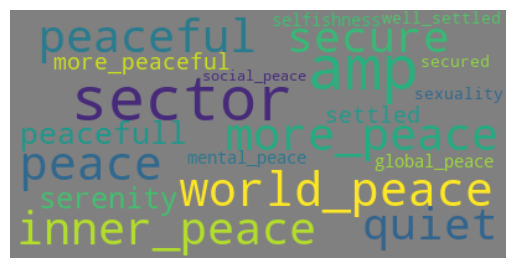

In [37]:
text = ""
for index, row in df.iterrows():
    text += row.lema_label + " "
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="grey").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

PD Negative Score

In [150]:
sql = f"""select topic.id, topic.label, count(form_topic.id) as nb_neg_form, sub_topic.nb_form, power(count(form_topic.id)::float,2)/sub_topic.nb_form as ratio from topic
join form_topic on form_topic.topic_id=topic.id
join form on form_topic.form_id=form.id
join stat on stat.id=form.id
join (select topic.id, count(form_topic.id) as nb_form from topic
	join form_topic on form_topic.topic_id=topic.id
	join form on form_topic.form_id=form.id
	join stat on stat.id=form.id
	where source='textrank'
	group by topic.id
	having count(form_topic.id) > {avg}
) sub_topic on sub_topic.id = topic.id
where source='textrank'
and stat.empathy_category=0
group by topic.id, sub_topic.nb_form
having count(form_topic.id) > {median}
order by ratio desc"""
df = service.get_by_sql(sql)
df.head(10)


,id,label,nb_neg_form,nb_form,ratio
0,5955,countries,50,2026,1.23
1,5998,world,45,2039,0.99
2,6021,good,38,1517,0.95
3,5980,peace,52,2898,0.93
4,5999,success,29,929,0.91
5,5987,better,31,1132,0.85
6,5995,money,19,458,0.79
7,5964,respect,27,1061,0.69
8,6033,millionaire,8,130,0.49
9,6036,person,16,522,0.49


In [49]:
topic = "countries"
sql = f"""select topic.label as topic_label, lema.label as lema_label, lema.count from topic
join lema on lema.topic_id=topic.id
where topic.label = '{topic}'
and source='textrank'
order by lema.count desc"""
df = service.get_by_sql(sql)
df.head(10)

,topic_label,lema_label,count
0,countries,countries,120
1,countries,comfort,115
2,countries,community,84
3,countries,conditions,70
4,countries,comfortable,52
5,countries,corruption,50
6,countries,company,48
7,countries,mutual,45
8,countries,common,42
9,countries,conflicts,42


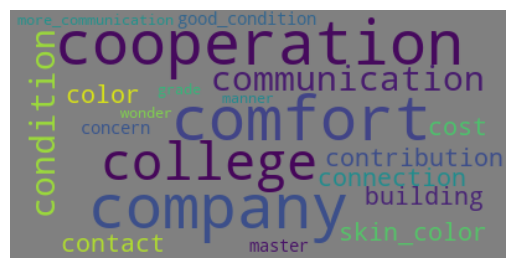

In [50]:
text = ""
for index, row in df.iterrows():
    text += row.lema_label + " "
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="grey").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

PD Positive Score

In [151]:
sql = f"""select topic.id, topic.label, count(form_topic.id) as nb_pos_form, sub_topic.nb_form, power(count(form_topic.id)::float,2)/sub_topic.nb_form as ratio from topic
join form_topic on form_topic.topic_id=topic.id
join form on form_topic.form_id=form.id
join stat on stat.id=form.id
join (select topic.id, count(form_topic.id) as nb_form from topic
	join form_topic on form_topic.topic_id=topic.id
	join form on form_topic.form_id=form.id
	join stat on stat.id=form.id
	where source='textrank'
	group by topic.id
	having count(form_topic.id) > {avg}
) sub_topic on sub_topic.id = topic.id
where source='textrank'
and stat.empathy_category=2
group by topic.id, sub_topic.nb_form
having count(form_topic.id) > {median}
order by ratio desc"""
df = service.get_by_sql(sql)
df.head(10)

,id,label,nb_pos_form,nb_form,ratio
0,5980,peace,1344,2898,623.30
1,5998,world,961,2039,452.93
2,5955,countries,939,2026,435.20
3,5960,life,763,1702,342.05
4,6012,people,608,1209,305.76
5,6048,happiness,630,1330,298.42
6,6021,good,664,1517,290.64
7,5987,better,546,1132,263.35
8,5964,respect,518,1061,252.90
9,6049,health,508,1183,218.14


In [52]:
topic = "peace"
sql = f"""select topic.label as topic_label, lema.label as lema_label, lema.count from topic
join lema on lema.topic_id=topic.id
where topic.label = '{topic}'
and source='textrank'
order by lema.count desc"""
df = service.get_by_sql(sql)
# df["lema_label"] = df["lema_label"].str.replace('_',' ')
df.head(10)

,topic_label,lema_label,count
0,peace,peace,2802
1,peace,world_peace,350
2,peace,peaceful,209
3,peace,more_peace,37
4,peace,inner_peace,25
5,peace,quiet,21
6,peace,secure,16
7,peace,peacefull,16
8,peace,serenity,14
9,peace,more_peaceful,13


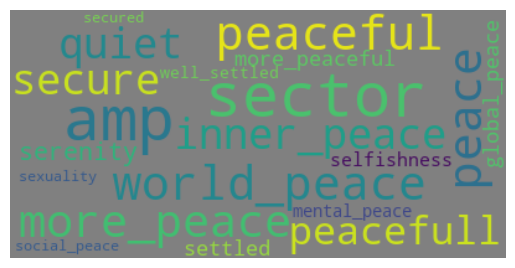

In [53]:
text = ""
for index, row in df.iterrows():
    text += row.lema_label + " "
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="grey").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Low Noise
857 topics
Low noise = 8
Very low = 1


In [174]:
low_noise = median - 3
very_low_noise = 1
low_noise

3

In [177]:
sql = f"""select topic.id, topic.label, count(form_topic.id) as nb_neg_form, sub_topic.nb_form, log(power(count(form_topic.id)::float,2)/power(2.7, sub_topic.nb_form)) as ratio from topic
join form_topic on form_topic.topic_id=topic.id
join form on form_topic.form_id=form.id
join stat on stat.id=form.id
join (select topic.id, count(form_topic.id) as nb_form from topic
	join form_topic on form_topic.topic_id=topic.id
	join form on form_topic.form_id=form.id
	join stat on stat.id=form.id
	where source='textrank'
	group by topic.id
	having count(form_topic.id) > 1 and count(form_topic.id) < 900
) sub_topic on sub_topic.id = topic.id
where source='textrank'
and stat.empathy_category=0
group by topic.id, sub_topic.nb_form
having count(form_topic.id) > {very_low_noise}
order by ratio desc"""
df = service.get_by_sql(sql)
df = df[df.label != "etre"]
df.head(10)

,id,label,nb_neg_form,nb_form,ratio
0,6812,lebanon,2,2,-0.26
1,6297,germany,2,3,-0.69
2,6983,domination,2,5,-1.55
4,7273,failure,2,6,-1.99
5,6911,pleasure,2,8,-2.85
6,6222,foreign,2,8,-2.85
7,6790,management,2,10,-3.71
8,6773,industry,2,11,-4.14
9,6705,fame,3,12,-4.22
10,6801,objectives,2,13,-5.01


In [169]:
topic = "millionaire"
sql = f"""select topic.label as topic_label, lema.label as lema_label, lema.count from topic
join lema on lema.topic_id=topic.id
where topic.label = '{topic}'
and source='textrank'
order by lema.count desc"""
df = service.get_by_sql(sql)
# df["lema_label"] = df["lema_label"].str.replace('_',' ')
df.head(10)

,topic_label,lema_label,count
0,millionaire,millionaire,21
1,millionaire,minimal,11
2,millionaire,minded,11
3,millionaire,middle,9
4,millionaire,minds,7
5,millionaire,minority,6
6,millionaire,open_minded,6
7,millionaire,mistakes,6
8,millionaire,million,5
9,millionaire,minimum,5


In [132]:
sql = """select topic.id, topic.label, count(form_topic.id) as nb_pos_form, sub_topic.nb_form, log(power(count(form_topic.id)::float,2)/power(2.7, sub_topic.nb_form)) as ratio from topic
join form_topic on form_topic.topic_id=topic.id
join form on form_topic.form_id=form.id
join stat on stat.id=form.id
join (select topic.id, count(form_topic.id) as nb_form from topic
	join form_topic on form_topic.topic_id=topic.id
	join form on form_topic.form_id=form.id
	join stat on stat.id=form.id
	where source='textrank'
	group by topic.id
	having count(form_topic.id) > 1 and count(form_topic.id) < 900
) sub_topic on sub_topic.id = topic.id
where source='textrank'
and stat.empathy_category=2
group by topic.id, sub_topic.nb_form
having count(form_topic.id) > 8
order by ratio desc"""
df = service.get_by_sql(sql)
df.head(10)

,id,label,nb_pos_form,nb_form,ratio
0,7131,gods,9,10,-2.405153
1,6842,truth,10,12,-3.176365
2,6518,judgement,10,14,-4.039093
3,7139,egalitarian,9,15,-4.561971
4,6104,eyes,10,16,-4.901820
5,6061,groups,10,16,-4.901820
6,6740,illness,9,16,-4.993335
7,6445,marriage,9,17,-5.424699
8,6920,signedheaders,11,18,-5.681762
9,6591,tomorrow,10,18,-5.764548
